### Imports
- Everthing which has remaze as focus

In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats 
from sklearn.model_selection import KFold, train_test_split
import subjects


### Scatter plot maze vs remaze

In [ ]:
pair_corr_df = []
for sub, sess in enumerate(sessions):
    maze = sess.paradigm["maze"].flatten()
    remaze = sess.paradigm["re-maze"].flatten()

    neurons = sess.neurons.get_neuron_type("pyr")
    maze_frate = neurons.time_slice(*maze).firing_rate
    remaze_frate = neurons.time_slice(*remaze).firing_rate

    good_indices = np.logical_and(maze_frate > 0, remaze_frate > 0)
    neurons = neurons[good_indices]

    pair_corr = []
    for e in [maze, remaze]:
        pair_corr.append(
            neurons.time_slice(*e).get_binned_spiketrains(0.25).get_pairwise_corr()
        )
    
    df = pd.DataFrame(dict(maze=pair_corr[0],remaze=pair_corr[1],grp=sess.tag))
    pair_corr_df.append(df)

pair_corr_df = pd.concat(pair_corr_df,ignore_index=True)

subjects.GroupData().save(pair_corr_df,'remaze_maze_paircorr')

In [ ]:
%matplotlib widget

import matplotlib.pyplot as plt
import seaborn as sns

sns.scatterplot(data=pair_corr_df,x='maze',y='remaze',hue='grp')


### Pairwise correlations between Zt5-end to remaze

In [ ]:
pair_corr_df = []
for sub, sess in enumerate(sessions):
    maze = sess.paradigm["maze"].flatten()
    post = sess.paradigm["post"].flatten()
    remaze = sess.paradigm["re-maze"].flatten()

    e1 = [post[0] + 5 * 3600,post[1]]
    e2 = remaze

    neurons = sess.neurons.get_neuron_type("pyr")
    e1_frate = neurons.time_slice(*e1).firing_rate
    e2_frate = neurons.time_slice(*e2).firing_rate

    good_indices = np.logical_and(e1_frate > 0, e2_frate > 0)
    neurons = neurons[good_indices]

    pair_corr = []
    for e in [e1, e2]:
        pair_corr.append(
            neurons.time_slice(*e).get_binned_spiketrains(0.25).get_pairwise_corr()
        )

    df = pd.DataFrame(dict(e1=pair_corr[0], e2=pair_corr[1], grp=sess.tag))
    pair_corr_df.append(df)

pair_corr_df = pd.concat(pair_corr_df, ignore_index=True)

subjects.GroupData().save(pair_corr_df, "remaze_last5_paircorr")


In [ ]:
%matplotlib widget

import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats 

_,axs = plt.subplots(1,2,sharex=True,sharey=True)
axs = axs.reshape(-1)
for i, grp in enumerate(['NSD','SD']):
    df = pair_corr_df[pair_corr_df['grp']==grp]
    linreg = stats.linregress(df['e1'],df['e2'])
    sns.scatterplot(data=df,x='e1',y='e2',hue='grp',ax=axs[i])
    axs[i].set_title(f'r={linreg.rvalue.round(2)}, pvalue={linreg.pvalue}')


### Pairwise correlations between Zt0-5 vs remaze
- Scatter plots 
- I saw that pairwise correlations during NSD are more correlated to remaze compared to SD.
- To carry out some statistical comparison between these two correlations, we can shuffle the pairs in each group and calculate R<sup>2</sup> difference and those distributions of R<sup>2</sup> difference between NSD and SD. 

In [3]:
sessions = subjects.nsd.remaze + subjects.sd.remaze

pair_corr_df = []
for sub, sess in enumerate(sessions):
    maze = sess.paradigm["maze"].flatten()
    post = sess.paradigm["post"].flatten()
    remaze = sess.paradigm["re-maze"].flatten()

    e1 = [post[0],post[0] + 5 * 3600]
    e2 = remaze

    neurons = sess.neurons.get_neuron_type("pyr")
    e1_frate = neurons.time_slice(*e1).firing_rate
    e2_frate = neurons.time_slice(*e2).firing_rate

    good_indices = np.logical_and(e1_frate > 0, e2_frate > 0)
    neurons = neurons[good_indices]

    pair_corr = []
    for e in [e1, e2]:
        pair_corr.append(
            neurons.time_slice(*e).get_binned_spiketrains(0.25).get_pairwise_corr()
        )

    df = pd.DataFrame(dict(zt5h=pair_corr[0], remaze=pair_corr[1], grp=sess.tag))
    pair_corr_df.append(df)

pair_corr_df = pd.concat(pair_corr_df, ignore_index=True)

subjects.GroupData().save(pair_corr_df, "remaze_first5_paircorr")

remaze_first5_paircorr saved


In [13]:
from neuropy.core import Epoch

a = sess.brainstates.to_dataframe()
Epoch(a)

352 epochs
Snippet: 
         start        stop   duration   label
0    0.500000    2.100026   1.600026    nrem
1    2.100026   58.900953  56.800927  active
2   58.900953  122.101984  63.201031   quiet
3  122.101984  126.902063   4.800078  active
4  126.902063  140.502285  13.600222     rem

In [12]:
a['start'] = a['start'].astype('str')

#### Shuffle/Bootstrapping methods
- Method 1: Randomize x axis correlations
- Method 2: Subsample x and y and get a distribution of R^2 values and then compare
- Method 3 (**Using this here**): Combined bootstrap, combine both SD and NSD pairwise correlations and then subsample the same number of pairs (for each group) with or without replacement and calclate the R^2 difference and compare their distributions between original group vs this new sampled groups. 

In [4]:
rng = np.random.default_rng()
subsample_df = []

r2,n_pairs=[],[]
for i, grp in enumerate(["NSD", "SD"]):
    df = pair_corr_df[pair_corr_df["grp"] == grp]
    x, y = df.zt5h.values, df.remaze.values
    linreg = stats.linregress(x, y)
    r2.append(linreg.rvalue**2)
    n_pairs.append(len(x))

r2_diff = -np.diff(r2) # multiple by -1 because NSD - SD
combined_paircorr = pair_corr_df.zt5h.values

r2_boot = []
for i, grp in enumerate(["NSD", "SD"]):
    y = pair_corr_df[pair_corr_df["grp"] == grp].remaze.values

    r2_grp = []
    for p in range(1000):
        x_boot = rng.choice(combined_paircorr,n_pairs[i],replace=False)
        linreg_boot = stats.linregress(x_boot,y)
        r2_grp.append(linreg_boot.rvalue**2)

    r2_boot.append(r2_grp)

r2_boot_diff = -np.diff(np.asarray(r2_boot),axis=0).squeeze()
r2_boot_diff_df=pd.DataFrame(dict(r2_diff=r2_boot_diff - r2_diff, grp=grp))

# subsample_df = pd.concat(subsample_df, ignore_index=True)

subjects.GroupData().save(r2_boot_diff_df,'remaze_first5_bootstrap')

remaze_first5_bootstrap saved


<AxesSubplot:xlabel='r2_diff', ylabel='Count'>

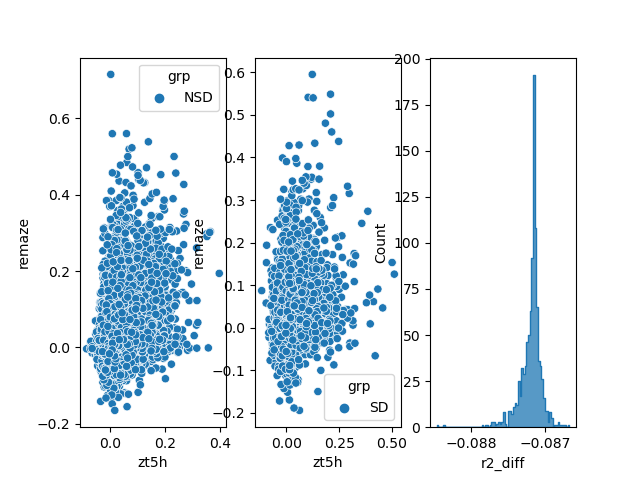

In [54]:
_,axs = plt.subplots(1,3)
axs = axs.reshape(-1)
for i, grp in enumerate(['NSD','SD']):
    df = pair_corr_df[pair_corr_df['grp']==grp]
    linreg = stats.linregress(df['zt5h'],df['remaze'])
    sns.scatterplot(data=df,x='zt5h',y='remaze',hue='grp',ax=axs[i])
    # axs[i].set_title(f'r={linreg.rvalue.round(2)}, pvalue={linreg.pvalue}')

sns.histplot(data=r2_boot_diff_df,x='r2_diff',ax=axs[2],fill=True,element='step')
# axs[2].axvline(0.08,ls='--')
# axs[2].set_xscale('log')

### Correlation of pairwise correlations across time for remaze sessions

In [ ]:
import pingouin as pg

corr=[]
for sub, sess in enumerate(sessions):
    rec_duration = sess.eegfile.duration
    neurons = sess.neurons.get_neuron_type("pyr")

    windows = np.arange(0, rec_duration, 300)
    pair_corr = []
    for w in windows[:-1]:
        pair_corr.append(
            neurons.time_slice(w,w+300).get_binned_spiketrains().get_pairwise_corr()
        )
    pair_corr = np.array(pair_corr).T
    df = pd.DataFrame(pair_corr,columns=np.arange(len(windows)-1))
    corr.append(df.corr().values)
subjects.GroupData().save(corr,'remaze_corr_across_session')

In [ ]:
%matplotlib widget
import matplotlib.pyplot as plt

_,axs = plt.subplots(1,2)
axs = axs.reshape(-1)

for i in range(2):
    axs[i].imshow(corr[i])
